In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory

import os
for dirname, _, filenames in os.walk(r'C:\Users\Bryan\OneDrive\Desktop\AML'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression



C:\Users\Bryan\OneDrive\Desktop\AML\calendar.csv
C:\Users\Bryan\OneDrive\Desktop\AML\listings.csv
C:\Users\Bryan\OneDrive\Desktop\AML\reviews.csv


# New Section

In [ ]:
_listings_raw = pd.read_csv(r'C:\Users\Bryan\OneDrive\Desktop\AML\listings.csv', index_col = "id")

_listings = _listings_raw.copy()

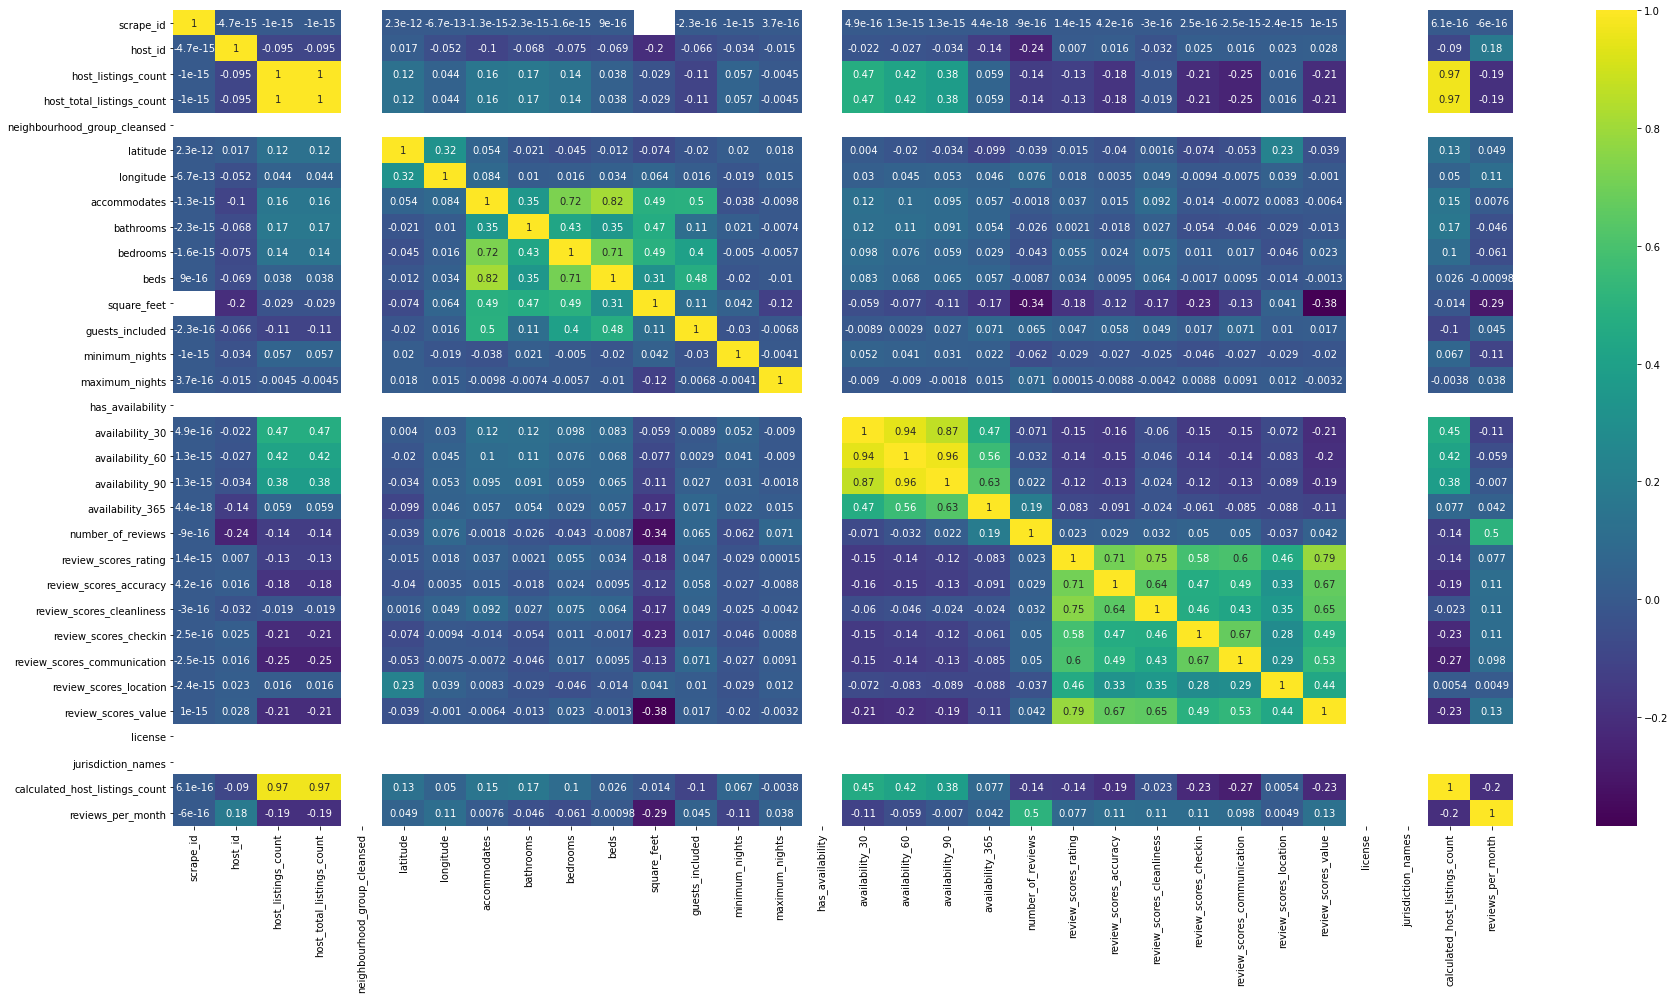

In [ ]:
plt.figure(figsize=(30,15))
#sns.heatmap(listing_2.corr(), annot=True)
#sns.heatmap(_listings_new.corr(), annot=True)
#sns.heatmap(_listings.corr(), annot=True)
sns.heatmap(_listings.corr(), annot=True, cmap='viridis', xticklabels = True, yticklabels = True)


plt.show()

In [ ]:
def clean_listing_dataset ():
    # step 1: remove columns from the data set that are not useful for price prediction
    # step 2: remove columns that has very high percentage of na values
    # step 3: transform price and other numeric columns from string to int,float type 
    _cols_to_drop = ['listing_url', 'thumbnail_url', 'medium_url', 'picture_url', 'picture_url', 
             'xl_picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url', 
             'state','country','country_code','market','requires_license',
            'experiences_offered','first_review', 'last_review','calendar_last_scraped',
       'calendar_updated', 'scrape_id', 'last_scraped', 'space', 'host_neighbourhood', 
        'neighborhood_overview', 'host_listings_count', 'zipcode', 'is_location_exact', 'host_location',
       'host_total_listings_count', 'neighbourhood','smart_location','host_id']
    # droping columns that are not useful
    _listings.drop(_cols_to_drop, axis=1, inplace=True)
    # droping columns having no values or less than thres
    _thresh = len(_listings) * .35
    _listings.dropna(axis=1,thresh=_thresh, inplace = True)
    # remove $ and comma from price cols, convert it to float and fill na values by mean/median
    for _price_fe in ["cleaning_fee", "security_deposit", "price", "extra_people"]:
        # remove $ and comma from price, ignore na values so that we wont get any errors.
        _listings[_price_fe] = _listings[_price_fe].map(lambda p : p.replace('$','').replace(',',''), na_action='ignore')
        # convert cols to float type
        _listings[_price_fe] = _listings[_price_fe].astype(float)
        # fill na values with mean/median
        _listings[_price_fe].fillna(_listings[_price_fe].median(), inplace=True)
    # remove % from rate cols and convert it to int
    for _rate in ['host_response_rate', 'host_acceptance_rate']:
        # replace % with blank
        _listings[_rate] = _listings[_rate].map(lambda r: r.replace('%',''), na_action='ignore')
        # fill na values with backfill or ffill
        _listings[_rate].fillna(method="backfill", inplace=True)
        # convert to int type
        _listings[_rate] = _listings[_rate].astype(int)
    _listings['host_response_time'].fillna(method="backfill", inplace=True)
    # drop rows having na of ["bathrooms", "bedrooms", "beds"] since they are less in number we can not put any assumption and add bias
    _listings.dropna(axis=0, subset=["bathrooms", "bedrooms", "beds"], inplace=True)
    # convert ["bathrooms", "bedrooms", "beds"] into int as they make more sense
    for _room in ["bathrooms", "bedrooms", "beds"]:
        _listings[_room] = _listings[_room].astype(int)
    for _review in ["review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", 
                    "review_scores_checkin", "review_scores_communication", "review_scores_location", 
                    "review_scores_value", "reviews_per_month"]:
        _listings[_review].fillna(_listings[_review].mean(), inplace=True)
    print('data set after cleaning ::')
    print(_listings.info())

clean_listing_dataset()    


data set after cleaning ::
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3557 entries, 12147973 to 14504422
Data columns (total 56 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   name                              3557 non-null   object 
 1   summary                           3431 non-null   object 
 2   description                       3557 non-null   object 
 3   notes                             1604 non-null   object 
 4   transit                           2287 non-null   object 
 5   access                            2089 non-null   object 
 6   interaction                       2024 non-null   object 
 7   house_rules                       2377 non-null   object 
 8   host_name                         3557 non-null   object 
 9   host_since                        3557 non-null   object 
 10  host_about                        2255 non-null   object 
 11  host_response_time             

<AxesSubplot:>

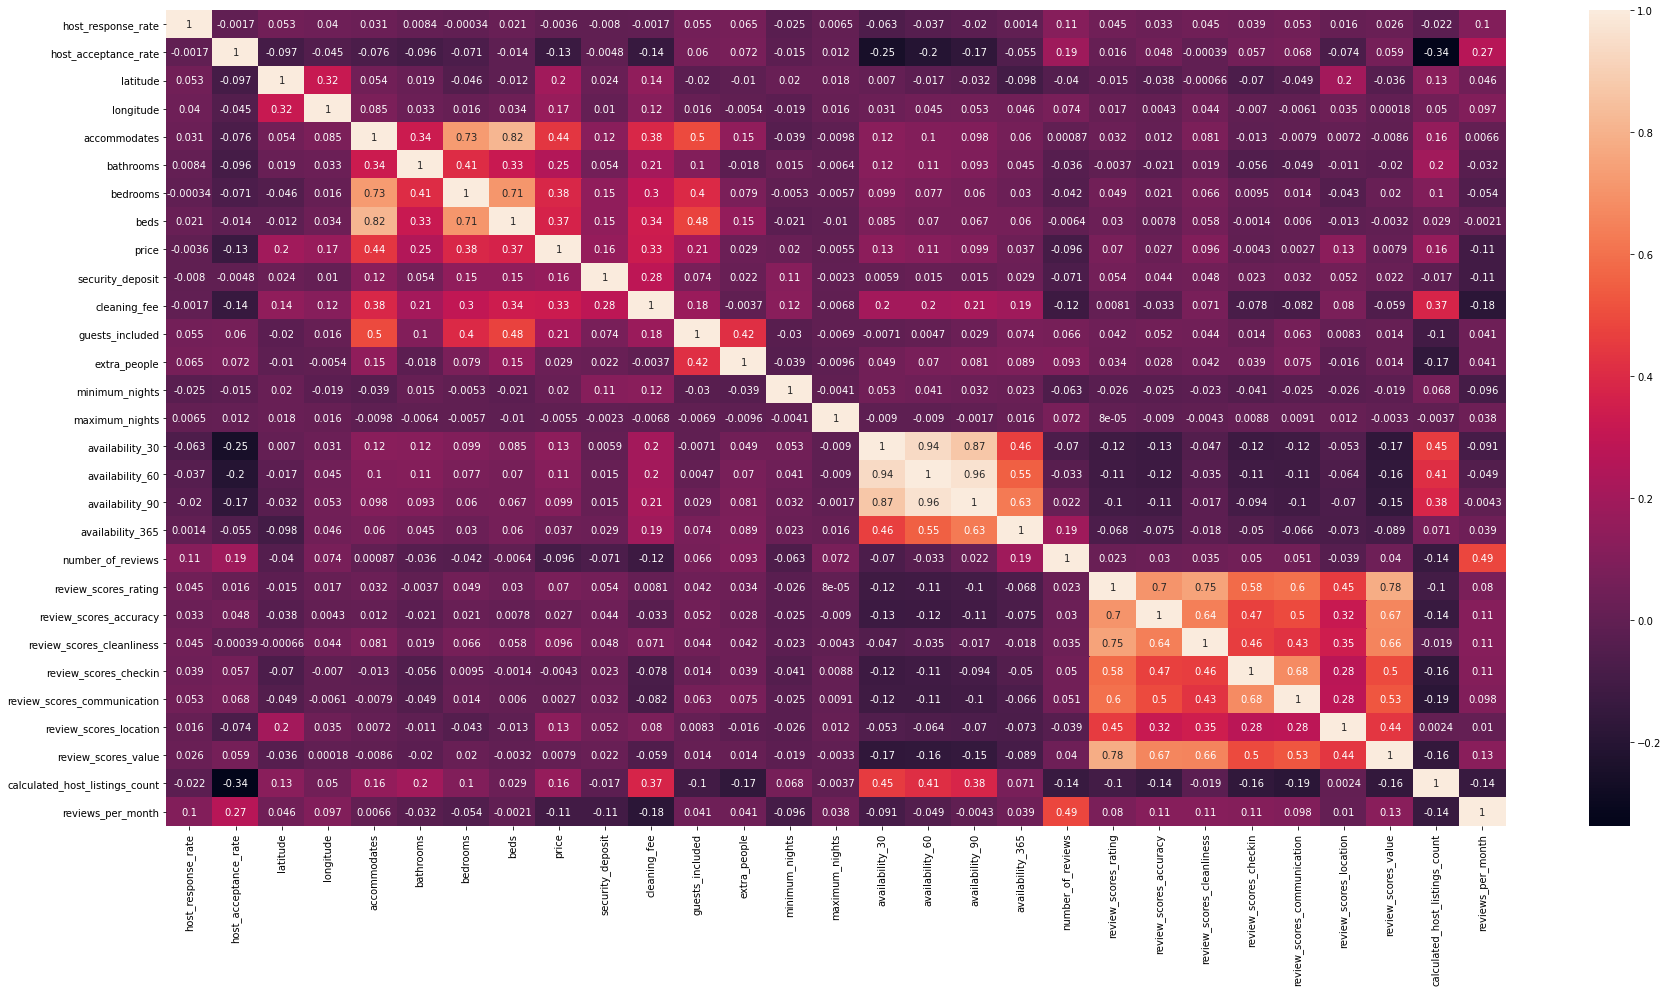

In [ ]:
plt.figure(figsize=(30,15))
#sns.heatmap(listing_2.corr(), annot=True)
#sns.heatmap(_listings_new.corr(), annot=True)
sns.heatmap(_listings.corr(), annot=True)

In [ ]:
# Drop null values of listing_2dr
listing_2 = _listings.reset_index()
listing_2dr = listing_2.dropna(axis = 0)

# The following features are the ones having high correlation with price
X = listing_2dr[["accommodates", "bathrooms", "bedrooms", "beds", "review_scores_location","availability_60","calculated_host_listings_count","availability_30","cleaning_fee","guests_included","latitude","longitude"]]
y = listing_2dr["price"]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

# Fit the train sets to Linear regression model
ln_model = LinearRegression(normalize = True)
ln_model.fit(X_train, y_train)

LinearRegression(normalize=True)

In [ ]:

# Predict using the model
y_test_predict = ln_model.predict(X_test)

# Score using the model
r2_test = r2_score(y_test, y_test_predict)
length_y_test = len(y_test)
print("The r-squared score for your model was {} on {} values.".format(r2_test, length_y_test))

The r-squared score for your model was 0.47982635119312145 on 267 values.


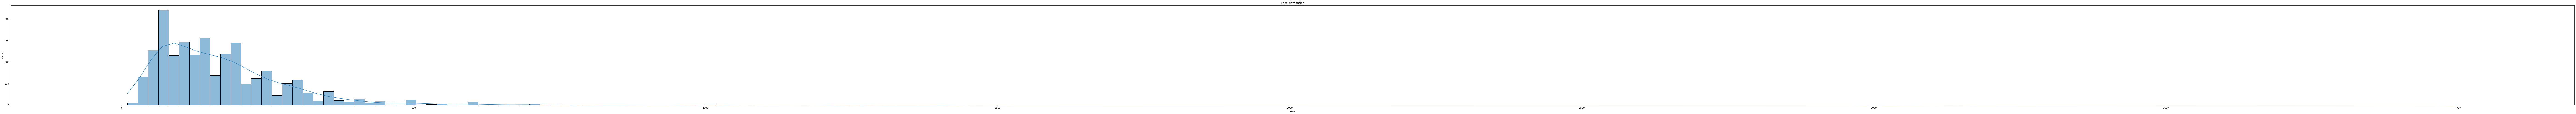

count    3557.000000
mean      174.136351
std       148.710580
min        10.000000
25%        85.000000
50%       150.000000
75%       220.000000
max      4000.000000
Name: price, dtype: float64


In [ ]:
plt.figure(figsize=(200,8))
plt.title('Price distribution')
sns.histplot(_listings['price'], kde=True, fill=True)
plt.show()

print(_listings['price'].describe())

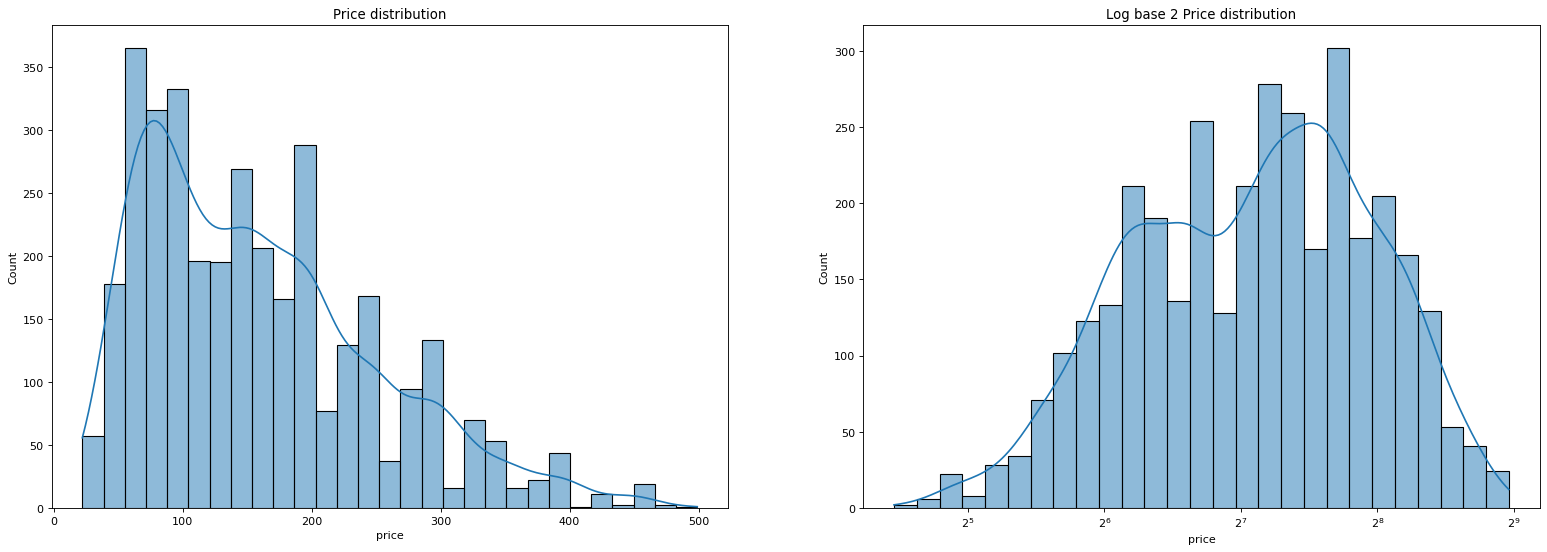

count    3557.000000
mean      174.136351
std       148.710580
min        10.000000
25%        85.000000
50%       150.000000
75%       220.000000
max      4000.000000
Name: price, dtype: float64


In [ ]:
# remove outliers
_listings_new = _listings[(_listings['price'] > 20) & (_listings['price'] < 500)]

fig, axs = plt.subplots(1, 2, figsize=(24, 8), dpi=80)
axs[0].set_title('Price distribution')
axs[1].set_title('Log base 2 Price distribution')
sns.histplot(_listings_new['price'], kde=True, ax=axs[0])
sns.histplot(_listings_new['price'].astype(int), kde=True, log_scale=2, ax=axs[1])
plt.show()

print(_listings['price'].describe())

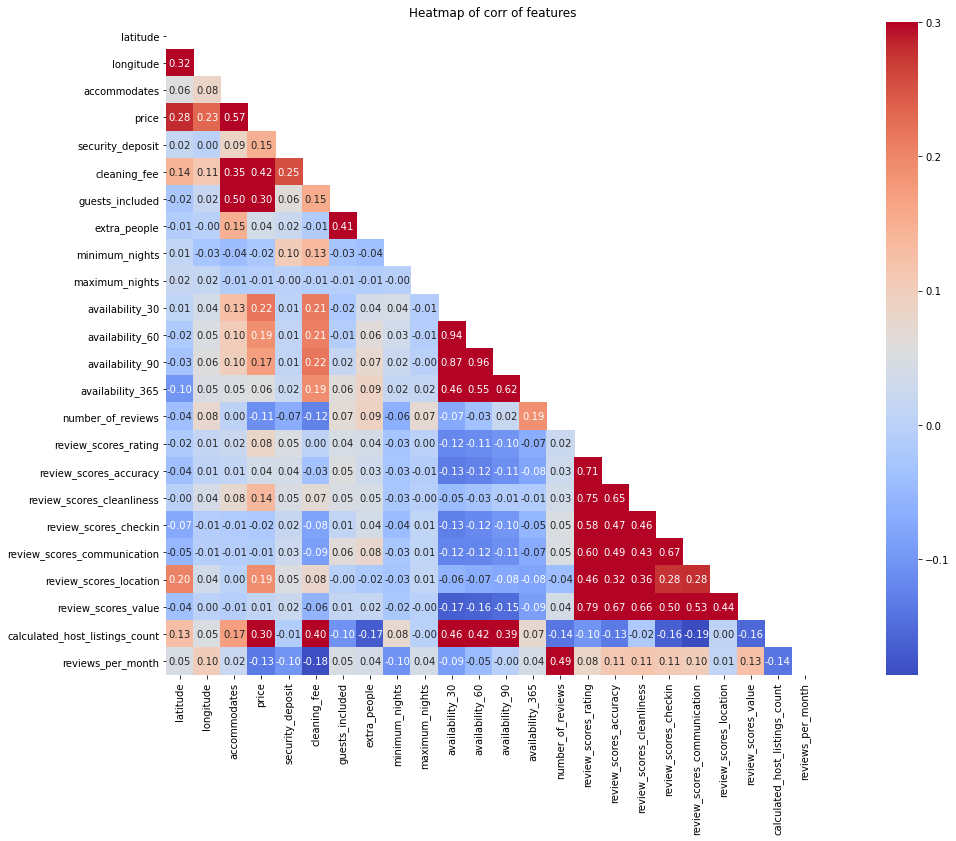

In [ ]:
_corr = _listings_new.select_dtypes(include=['int64', 'float64']).corr()
_mask = np.zeros_like(_corr)
_mask[np.triu_indices_from(_mask)] = True
plt.figure(figsize=(24,12))
plt.title('Heatmap of corr of features')
sb.heatmap(_corr, mask = _mask, vmax=.3, square=True, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

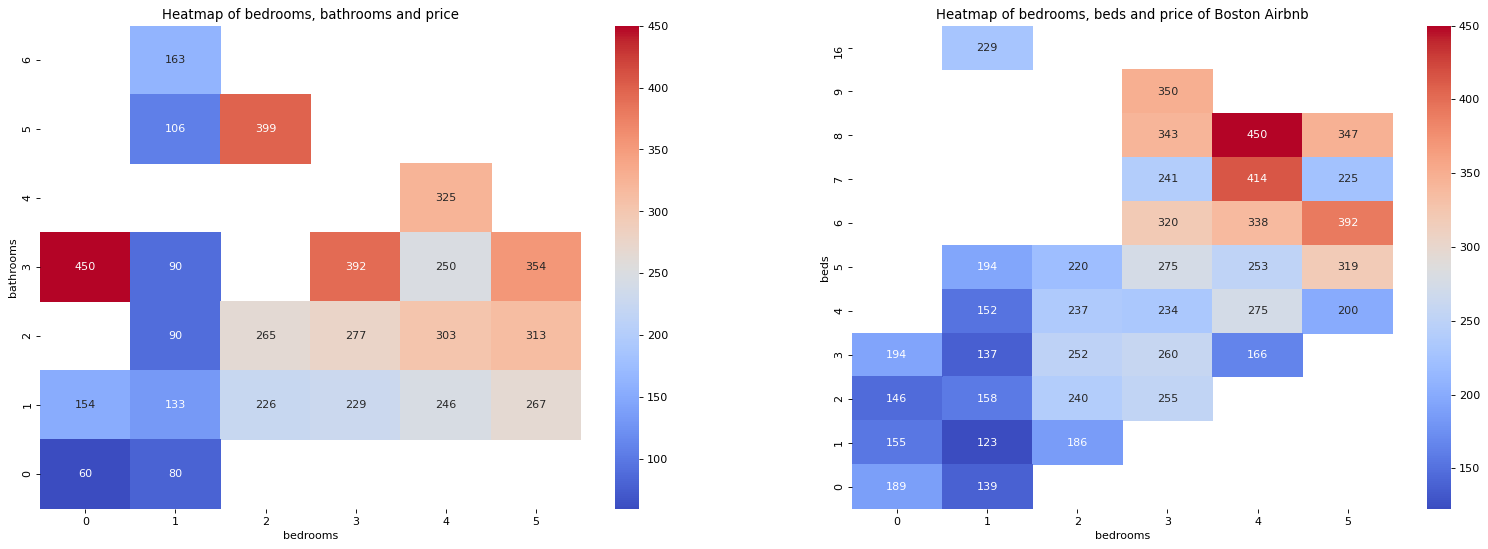

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(24, 8), dpi=80)
axs[0].set_title('Heatmap of bedrooms, bathrooms and price')
axs[1].set_title('Heatmap of bedrooms, beds and price of Boston Airbnb')

_mean_price_bbb = _listings_new.groupby(['bathrooms', 'bedrooms']).mean().price.reset_index().pivot('bathrooms','bedrooms','price').sort_index(ascending=False)
_mean_price_bbb_1 = _listings_new.groupby(['beds', 'bedrooms']).mean().price.reset_index().pivot('beds','bedrooms','price').sort_index(ascending=False)

sns.heatmap(_mean_price_bbb, cmap="coolwarm", fmt='.0f', annot=True, ax=axs[0])
sns.heatmap(_mean_price_bbb_1, cmap="coolwarm", fmt='.0f', annot=True, ax=axs[1])
plt.show()


In [ ]:
_listings_new = _listings_new.drop(_listings_new[_listings_new['bedrooms']==0].index)
_listings_new.shape

(3176, 56)

In [ ]:
_listings_new.select_dtypes(include=['object']).info()

In [ ]:
plt.figure(figsize=(28,8))
plt.title("Price distribution across neighbourhood")

sns.boxplot(data=_listings_new, x='neighbourhood_cleansed', y='price')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)

plt.ylim([0,500])
plt.legend()
plt.show()

In [ ]:
_neighb = _listings_new['neighbourhood_cleansed'].value_counts().sort_values(ascending=False).reset_index(name='count').rename(columns = {'index':'neighbourhood'})
plt.figure(figsize=(28,8))
plt.title("Distribution of price in neighbourhoods")
sns.barplot(data=_neighb, x='neighbourhood', y='count')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
plt.legend()
plt.show()

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(30, 20), dpi=90)

axs[0,0].set_title('property_type vs price')
p1 = sns.boxplot(data=_listings_new, x='property_type', y='price', ax=axs[0,0])
p1.set_xticklabels(p1.get_xticklabels(), rotation=25, ha='right', fontsize=12)

axs[0,1].set_title('room_type vs price')
sns.boxplot(data=_listings_new, x='room_type', y='price', ax=axs[0,1])

axs[1,0].set_title('bed_type vs price')
sns.boxplot(data=_listings_new, x='bed_type', y='price', ax=axs[1,0])

axs[1,1].set_title('cancellation_policy vs price')
sns.boxplot(data=_listings_new, x='cancellation_policy', y='price', ax=axs[1,1])

axs[2,0].set_title('host_is_superhost vs price')
sns.boxplot(data=_listings_new, x='host_is_superhost', y='price', ax=axs[2,0])

axs[2,1].set_title('instant_bookable vs price')
sns.boxplot(data=_listings_new, x='instant_bookable', y='price', ax=axs[2,1])

axs[3,0].set_title('host_identity_verified vs price')
sns.boxplot(data=_listings_new, x='host_identity_verified', y='price', ax=axs[3,0])

axs[3,1].set_title('require_guest_phone_verification vs price')
sns.boxplot(data=_listings_new, x='require_guest_phone_verification', y='price', ax=axs[3,1])

plt.ylim([0,500])
plt.legend()
plt.show()

In [ ]:
_listings_new.select_dtypes(include=['object']).info()

In [ ]:
# select numeric cols
_num_cols = ['price', 'latitude','longitude', 'accommodates', 'bedrooms', 'bathrooms', 'beds', 'security_deposit', 
             'cleaning_fee', 'guests_included', 'availability_30', 'availability_60', 'availability_90', 
             'availability_365', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
             'review_scores_location', 'review_scores_value', 'calculated_host_listings_count']

_numeric = _listings_new.select_dtypes(include=['int64', 'float64'])[_num_cols]
print(_numeric.info())

# transform categorical columns into numeric and prepare new data frame
_cat_cols = ['host_response_time', 'host_is_superhost', 'room_type', 'bed_type', 'neighbourhood_cleansed',
             'cancellation_policy', 'property_type', 'host_identity_verified', 'instant_bookable',
            'host_has_profile_pic', 'require_guest_profile_picture', 'require_guest_phone_verification']

_numeric[_cat_cols] = _listings_new[_cat_cols]

_num_copy = _numeric.copy()

_num_copy = _num_copy.replace({ "host_is_superhost": {"t": 1, "f": 2}, "instant_bookable": {"t": 1, "f": 2}, 
                                "host_identity_verified": {"t": 1, "f": 2}, "require_guest_profile_picture": {"t": 1, "f": 2},
                                "room_type": {"Entire home/apt": 1, "Private room": 2, "Shared room": 3}, "host_has_profile_pic": {"t": 1, "f": 2},
                               "bed_type": {"Real Bed": 1, "Futon": 2, "Airbed": 3, "Pull-out Sofa": 4, "Couch": 5},
                               "require_guest_phone_verification": {"t": 1, "f": 2},
                               "cancellation_policy": {"moderate": 1, "flexible": 2, "strict": 3, "super_strict_30": 4}})

_dummies = pd.get_dummies(_num_copy)
print(_dummies.info())

In [ ]:
# model to predict pricing
y = np.log2(_dummies['price'].astype(int))
X = _dummies.drop('price',  axis =1 )

# split test and train dataset from X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=45)

def evaluate_model(_model, x_train, y_train, x_test, y_test):
    _model.fit(x_train, y_train)
    _prediction = _model.predict(x_test)
    _mean_abs_err = mean_absolute_error(y_test, _prediction)
    
    fig, axs = plt.subplots(1, 2, figsize=(24, 8), dpi=80)
    axs[0].set_title('Distribution of predicted vs actual values')
    ax1 = sns.kdeplot(data=y_test, color="g", label='Actual values', ax=axs[0])
    ax2 = sns.kdeplot(data=_prediction, color="b", label='Predicted values', ax=ax1)
    
    sns.regplot(x=y_test, y=_prediction)
    plt.title('Distribution of predicted vs actual values')
    plt.xlabel('Price')
    plt.legend()
    plt.show()
    plt.close()
    
    print("Mean absolute error of {0}: {1}".format(_model, _mean_abs_err))

# Create instance of Random Forest Regressor and evaluate model
_model_rf = RandomForestRegressor(n_estimators=76, random_state=47)    
evaluate_model(_model_rf, X_train, y_train, X_test, y_test)

# Create instance of Linear Regressor and evaluate the same
_model_lr = LinearRegression()
evaluate_model(_model_lr, X_train, y_train, X_test, y_test)